#**Detección de anomalias en un conjunto patrones de acceso a la API en términos de métricas de comportamiento**





***CONTEXTO***

Normalmente se accede a las aplicaciones distribuidas basadas en microservicios a través de API. Estas API son utilizadas por las aplicaciones o se puede acceder a ellas directamente por medios programáticos. Muchas veces el acceso a las APIs es abusado por atacantes que intentan explotar la lógica de negocio expuesta por estas APIs. La forma en que los usuarios normales acceden a estas API es diferente de la forma en que los atacantes acceden a estas API. Muchas aplicaciones tienen cientos de APIs que son llamadas en un orden específico y dependiendo de varios factores como refrescos del navegador, refrescos de sesión, errores de red, o acceso programático estos comportamientos no son estáticos y pueden variar para el mismo usuario. Las llamadas a la API en sesiones de larga duración forman gráficos de acceso que deben analizarse para descubrir patrones de ataque y anomalías. Los gráficos no se prestan al cálculo numérico. Abordamos este problema y proporcionamos un conjunto de datos en el que el comportamiento de acceso de los usuarios se califica como características numéricas. Además, proporcionamos un conjunto de datos con gráficos de llamadas API sin procesar. Para facilitar el uso de estos conjuntos de datos, también se incluyen dos cuadernos sobre clasificación, incrustación de nodos y agrupación.

*Se cuenta con conjunto de datos en el que el comportamiento de acceso de los usuarios se califica como características numéricas. Además, proporcionamos un conjunto de datos con gráficos de llamadas API sin procesar. Para facilitar el uso de estos conjuntos de datos, también se incluyen dos cuadernos sobre clasificación, incrustación de nodos y agrupación.*


In [1]:
!pip install pyspark
!pip install sktime
!pip install graphframes
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=55097839e8cc480822bb4547b24586b881312c3a47f55f909707a0b6647521c1
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.4 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    931      0 --:--:-- --:--:-- --:--:--   937
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create 

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [3]:
spark = SparkSession.builder.master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **CARGA DE DATOS**

In [24]:
dataS = spark.read.csv("/content/drive/MyDrive/datasets/G8-GR-MICROSERVICIOS/supervised_dataset.csv",header=True)
dataS.show(10)
dataR = spark.read.csv("/content/drive/MyDrive/datasets/G8-GR-MICROSERVICIOS/remaining_behavior_ext.csv",header=True)
dataR.show(10)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|num_sessions|num_users|num_unique_apis|source|classification|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|  0|1f2c32d8-2d6e-3b6...|          0.000812213726692...| 0.004066433440328921|     85.64324324324325|                  5405|default|      1460.0|   1295.0|          451.0|     E|        normal|
|  1|4c486414-d4f5-33f...|          6.324646128836197...| 0.002211465938298636|    16.166804782763112|                   519|default|      9299.0|   8447.0|          302.0|     E|        normal|
|  2|7e5838fc-bce1-371...

## **LIMPIEZA DE DATOS**

Este método se utiliza para eliminar filas que contienen valores faltantes (NaN) en un DataFrame. Los valores faltantes pueden ser problemáticos para muchos análisis y algoritmos, por lo que en ocasiones es necesario eliminar esas filas antes de realizar ciertas operaciones.

In [25]:
dataS.drop_duplicates()
dataS.na.drop()

DataFrame[_c0: string, _id: string, inter_api_access_duration(sec): string, api_access_uniqueness: string, sequence_length(count): string, vsession_duration(min): string, ip_type: string, num_sessions: string, num_users: string, num_unique_apis: string, source: string, classification: string]

In [26]:
dataR.drop_duplicates()
dataR.na.drop()

DataFrame[_c0: string, _id: string, inter_api_access_duration(sec): string, api_access_uniqueness: string, sequence_length(count): string, vsession_duration(min): string, ip_type: string, behavior: string, behavior_type: string, num_sessions: string, num_users: string, num_unique_apis: string, source: string]

In [27]:
dataS.printSchema()
dataR.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): string (nullable = true)
 |-- api_access_uniqueness: string (nullable = true)
 |-- sequence_length(count): string (nullable = true)
 |-- vsession_duration(min): string (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- num_sessions: string (nullable = true)
 |-- num_users: string (nullable = true)
 |-- num_unique_apis: string (nullable = true)
 |-- source: string (nullable = true)
 |-- classification: string (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): string (nullable = true)
 |-- api_access_uniqueness: string (nullable = true)
 |-- sequence_length(count): string (nullable = true)
 |-- vsession_duration(min): string (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- num_sessions: strin

## **Pre-procesamiento**

In [28]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

dataS = dataS.withColumn("inter_api_access_duration(sec)", col("inter_api_access_duration(sec)").cast("float")) \
       .withColumn("api_access_uniqueness", col("api_access_uniqueness").cast("float")) \
       .withColumn("sequence_length(count)", col("sequence_length(count)").cast(IntegerType())) \
       .withColumn("vsession_duration(min)", col("vsession_duration(min)").cast(IntegerType())) \
       .withColumn("num_sessions", col("num_sessions").cast(IntegerType())) \
       .withColumn("num_users", col("num_users").cast(IntegerType())) \
       .withColumn("num_unique_apis", col("num_unique_apis").cast(IntegerType()))
dataS.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): float (nullable = true)
 |-- api_access_uniqueness: float (nullable = true)
 |-- sequence_length(count): integer (nullable = true)
 |-- vsession_duration(min): integer (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- num_users: integer (nullable = true)
 |-- num_unique_apis: integer (nullable = true)
 |-- source: string (nullable = true)
 |-- classification: string (nullable = true)



In [29]:
dataS.show(10)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|num_sessions|num_users|num_unique_apis|source|classification|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+------------+---------+---------------+------+--------------+
|  0|1f2c32d8-2d6e-3b6...|                  8.1221375E-4|         0.0040664333|                    85|                  5405|default|        1460|     1295|            451|     E|        normal|
|  1|4c486414-d4f5-33f...|                   6.324646E-5|          0.002211466|                    16|                   519|default|        9299|     8447|            302|     E|        normal|
|  2|7e5838fc-bce1-371...

In [30]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

dataR = dataR.withColumn("inter_api_access_duration(sec)", col("inter_api_access_duration(sec)").cast("float")) \
       .withColumn("api_access_uniqueness", col("api_access_uniqueness").cast("float")) \
       .withColumn("sequence_length(count)", col("sequence_length(count)").cast(IntegerType())) \
       .withColumn("vsession_duration(min)", col("vsession_duration(min)").cast(IntegerType())) \
       .withColumn("num_sessions", col("num_sessions").cast(IntegerType())) \
       .withColumn("num_users", col("num_users").cast(IntegerType())) \
       .withColumn("num_unique_apis", col("num_unique_apis").cast(IntegerType()))
dataR.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- inter_api_access_duration(sec): float (nullable = true)
 |-- api_access_uniqueness: float (nullable = true)
 |-- sequence_length(count): integer (nullable = true)
 |-- vsession_duration(min): integer (nullable = true)
 |-- ip_type: string (nullable = true)
 |-- behavior: string (nullable = true)
 |-- behavior_type: string (nullable = true)
 |-- num_sessions: integer (nullable = true)
 |-- num_users: integer (nullable = true)
 |-- num_unique_apis: integer (nullable = true)
 |-- source: string (nullable = true)



In [31]:
dataR.show(5)

+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+--------+-------------+------------+---------+---------------+------+
|_c0|                 _id|inter_api_access_duration(sec)|api_access_uniqueness|sequence_length(count)|vsession_duration(min)|ip_type|behavior|behavior_type|num_sessions|num_users|num_unique_apis|source|
+---+--------------------+------------------------------+---------------------+----------------------+----------------------+-------+--------+-------------+------------+---------+---------------+------+
|  0|024aae60-1a81-3f3...|                      7.010387|           0.41935483|                    31|                 13040|default| outlier|      outlier|           1|        1|             13|     E|
|  1|028d67dd-c6d0-329...|                      51.41939|           0.25233644|                   107|                330113|default| outlier|      outlier|           1|        1|         

## **VISUALIZACIONES CON ANÁLISIS**

### ***ANÁLISIS EXPLORATORIO***

In [32]:
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [33]:
dfSupervisado = dataS.toPandas()

In [34]:
dfRestante = dataR.toPandas()

*Este histograma muestra la distribución de la duración de los accesos a una API específica dentro del sistema en segundos. Cada barra en el histograma representa un intervalo de tiempo y la altura de la barra muestra la cantidad de accesos que ocurrieron dentro de ese intervalo.*

array([[<Axes: title={'center': 'inter_api_access_duration(sec)'}>,
        <Axes: title={'center': 'api_access_uniqueness'}>,
        <Axes: title={'center': 'sequence_length(count)'}>],
       [<Axes: title={'center': 'vsession_duration(min)'}>,
        <Axes: title={'center': 'num_sessions'}>,
        <Axes: title={'center': 'num_users'}>],
       [<Axes: title={'center': 'num_unique_apis'}>, <Axes: >, <Axes: >]],
      dtype=object)

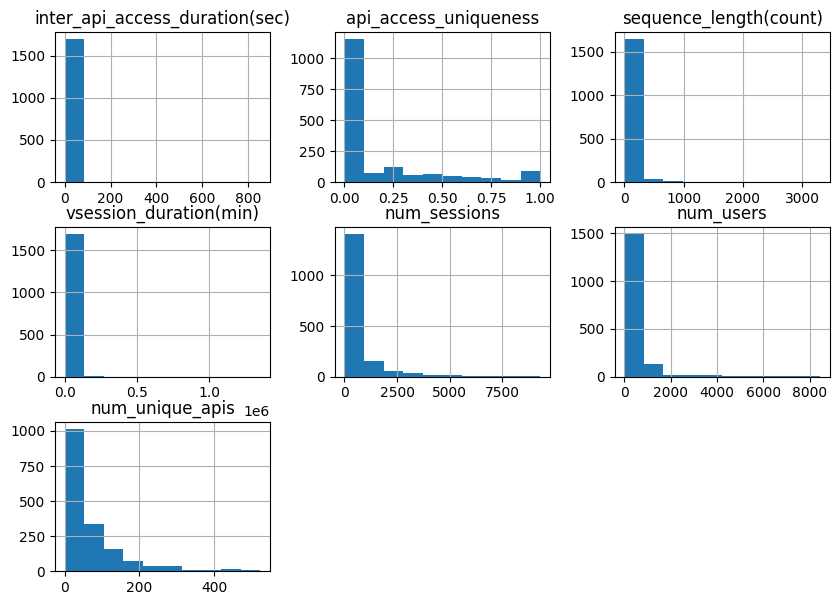

In [36]:
dfSupervisado.hist(figsize=(10,7))

La caja (boxplot) representa la distribución del número de API únicas en el conjunto de datos,  cuando se considera solo aquellos registros donde la longitud de la secuencia es menor a 50,000.

<ipython-input-37-1ec5b7fec253>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfSupervisado[dfRestante['sequence_length(count)']<50000]['num_unique_apis'].plot.box(color = color , vert=True)


<Axes: >

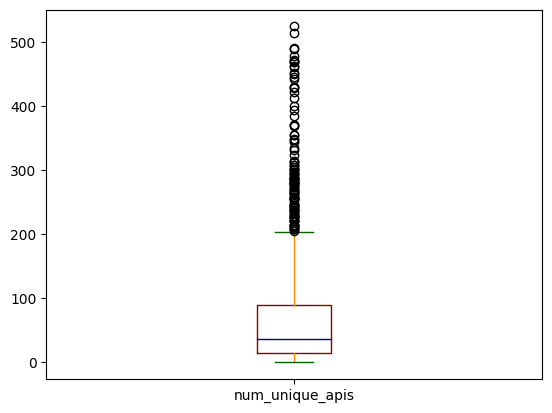

In [37]:
color = {
    "boxes" : "DarkRed",
    "whiskers" : "DarkOrange",
    "medians" : "DarkBlue",
    "caps" : "DarkGreen"
}
dfSupervisado[dfRestante['sequence_length(count)']<50000]['num_unique_apis'].plot.box(color = color , vert=True)

En este gráfico:

El eje X (horizontal) representa la variable "num_sessions", que indica el número de sesiones realizadas por los usuarios.
El eje Y (vertical) representa la variable "vsession_duration(min)", que indica la duración de la sesión virtual en minutos.
Cada punto en el gráfico representa un registro en el conjunto de datos "dfSupervisado". La posición de cada punto se determina por los valores de "num_sessions" y "vsession_duration(min)" para ese registro específico.

La transparencia de los puntos está configurada mediante el parámetro "alpha=0.5", lo que significa que los puntos serán semi-transparentes. Esto puede ser útil cuando hay muchos puntos superpuestos y se desea visualizar mejor las densidades y patrones en los datos.
La finalidad de este tipo de gráfico de dispersión es visualizar la relación o la distribución conjunta entre las dos variables.

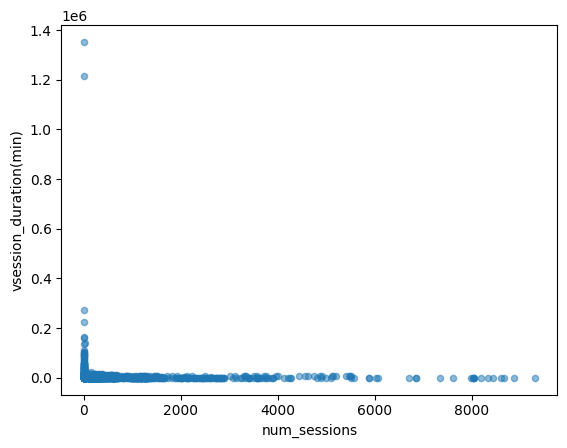

In [38]:
var = 'num_sessions'
data = pd.concat([dfSupervisado['vsession_duration(min)'], dfSupervisado[var]], axis=1)
data.plot.scatter(x=var, y='vsession_duration(min)', alpha = 0.5);

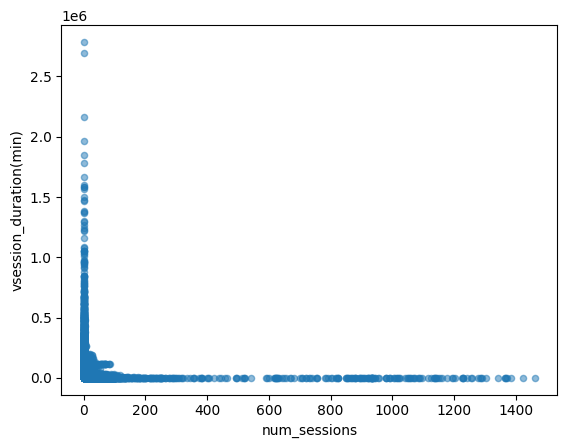

In [40]:
# Diagrama de dispersión

var = 'num_sessions'
data = pd.concat([dfRestante['vsession_duration(min)'], dfRestante[var]], axis=1)
data.plot.scatter(x=var, y='vsession_duration(min)', alpha = 0.5);

Se realiza una visualización de datos en forma de un gráfico de caja para analizar cómo se distribuyen las longitudes de secuencia ('sequence_length(count)') en función de la variable 'classification'. Cada categoría dentro de 'classification' tendrá su propia caja en el gráfico, mostrando la distribución de las longitudes de secuencia asociadas con esa categoría.

Los límites del eje y están establecidos entre 0 y 300 para limitar el rango de valores mostrados en el gráfico.

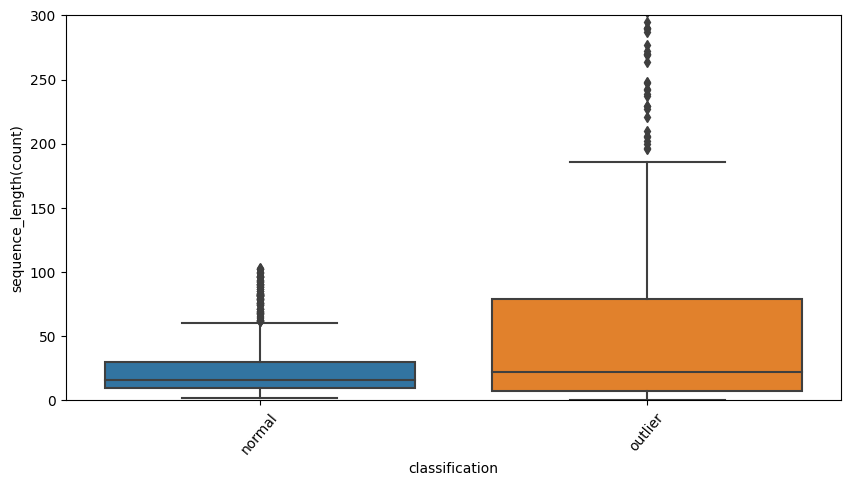

In [41]:
var = 'classification'
data = pd.concat([dfSupervisado['sequence_length(count)'], dfSupervisado[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x=var, y="sequence_length(count)", data=data)
fig.axis(ymin=0, ymax=300);
plt.xticks(rotation=50);

El gráfico de dispersión muestra la relación entre dos variables numéricas y es útil para visualizar cómo se distribuyen los datos y si existe alguna relación entre las variables.

<Axes: >

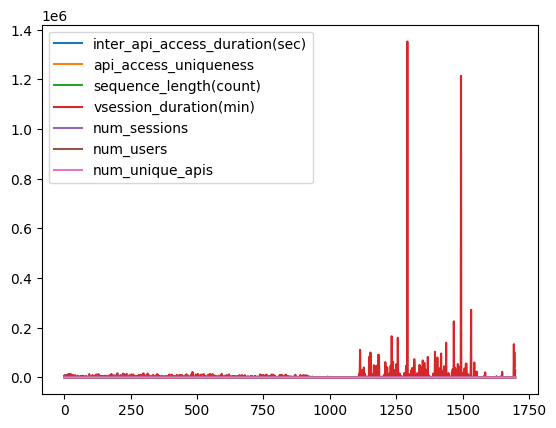

In [42]:
dfSupervisado.plot()

El gráfico generado mostrará cómo las columnas "vsession_duration(min)", "por encima" y "por abajo" cambian a lo largo del índice del DataFrame. Esto puede ser útil para visualizar cómo los límites se ajustan a los datos y detectar posibles valores atípicos o tendencias en la columna "vsession_duration(min)".

<Axes: >

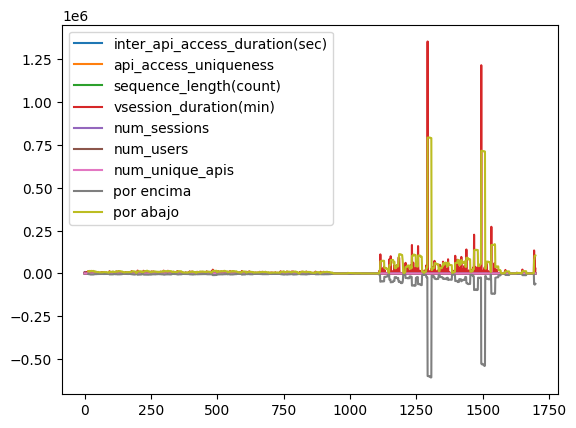

In [43]:
wind = 15
sigma = 2

dfSupervisado["por encima"] = dfSupervisado["vsession_duration(min)"].rolling(window=wind)\
    .mean() - (sigma * dfSupervisado["vsession_duration(min)"].rolling(window=wind).std())
dfSupervisado["por abajo"] = dfSupervisado["vsession_duration(min)"].rolling(window=wind)\
    .mean() + (sigma * dfSupervisado["vsession_duration(min)"].rolling(window=wind).std())
dfSupervisado.plot()

## **Diseño Modelos a evaluar**

In [44]:
import networkx as nx
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [45]:
# Crear un grafo a partir de un Dataframe
# ======================================================================================
G = nx.from_pandas_edgelist(dfSupervisado, source="sequence_length(count)", target="num_unique_apis")

In [46]:
adjM = nx.adjacency_matrix(G)
adjM = adjM.todense()
adjM

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
print("Número de nodos:", G.number_of_nodes())
print("Número de enlaces:", G.number_of_edges())

Número de nodos: 344
Número de enlaces: 1180


In [48]:
nodo_id = 15
vecinos = list(G.neighbors(nodo_id))
print("Vecinos del nodo {nodo_id}:", vecinos)

grado = G.degree[nodo_id]
print("Grado del nodo {nodo_id}:", grado)

Vecinos del nodo {nodo_id}: [241, 221, 37, 2, 295, 164, 163, 31, 169, 187, 146, 22, 162, 246, 254, 273, 19, 203, 188, 32, 181, 21, 6, 84, 214, 111, 26, 13, 58, 135, 24, 39, 40, 29, 38, 167, 25, 34, 9, 55, 28, 10, 11, 59, 12, 46, 8, 50, 3, 54, 63, 64, 4]
Grado del nodo {nodo_id}: 53


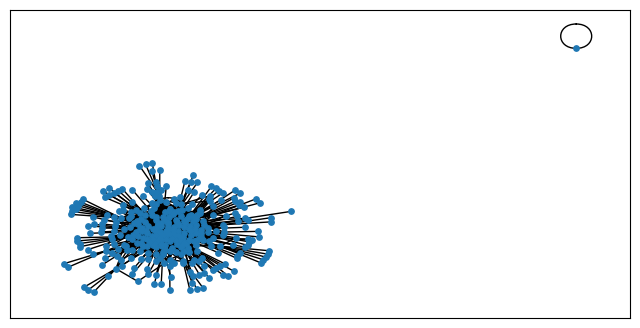

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
spring_pos = nx.spring_layout(G)
nx.draw_networkx(
    G, pos=spring_pos, with_labels=False, node_size=15, ax=ax
)

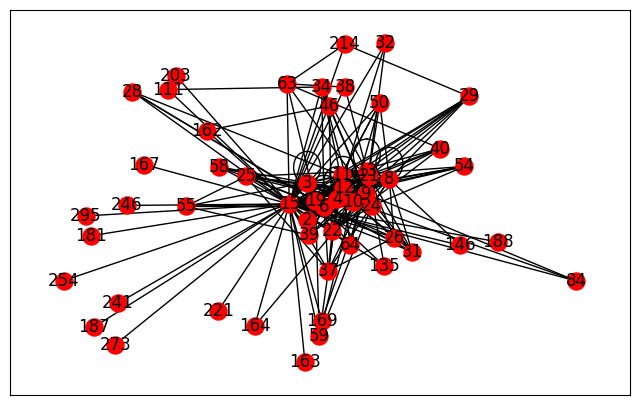

In [50]:
nodos = vecinos + [nodo_id]
G_s = nx.subgraph(G, nodos)

fig, ax = plt.subplots(figsize=(8, 5))
nx.draw_networkx(G_s, pos=spring_pos, with_labels=True, node_size=150, node_color='r', ax=ax)